In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
from time import time
# import dill
import pickle
import glob
import importlib
import numpy as np
import scipy as sp
import scipy.misc
import pandas as pd
import re
import itertools
from scanf import scanf
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm, PowerNorm, Normalize
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate, optimize, sparse
from scipy.interpolate import interp1d, interp2d
from IPython.display import display, HTML, Math
from scipy import interpolate
from tqdm.notebook import tqdm as tqdm_notebook

from src import slenderBodyTheory as slb
from src.geo import *
from src.objComposite import *
from codeStore import support_fun as spf
from codeStore.support_fun_head_tail import *
from codeStore.support_fun_tail_rotate import *

PWD = os.getcwd()
np.set_printoptions(linewidth=110, precision=5)

params = {'animation.html': 'html5',
          'font.family':    'sans-serif',
          'font.size':      15, }
preamble = r' '
preamble = preamble + '\\usepackage{bm} '
preamble = preamble + '\\usepackage{amsmath} '
preamble = preamble + '\\usepackage{amssymb} '
preamble = preamble + '\\usepackage{mathrsfs} '
preamble = preamble + '\\DeclareMathOperator{\\Tr}{Tr} '
preamble = preamble + '\\newcommand{\\norm}[1]{\\left\\lVert#1\\right\\rVert}'
params['text.latex.preamble'] = preamble
params['text.usetex'] = True
plt.rcParams.update(params)


In [2]:
def wrapper_slice_ft(fgeo, force, problem_kwargs):
    tf = force.reshape((-1, fgeo.get_dof()))
    ds = np.mean(np.linalg.norm(fgeo.axisNodes[:-1] - fgeo.axisNodes[1:], axis=-1))
    arc_x, arc_ft = get_slice_ft(fgeo, fgeo, tf, fgeo.get_nodes(), problem_kwargs)
    return arc_x[1:-1], arc_ft[1:-1] / ds

## varify the fitting formulation of the components of the force distribution along the helix cnter line. 

In [3]:
# motion along the x axis, \\mathbb{A}^v_{00}$

def func_AFx(x, a0, a1):
    y = a0 * np.cos(4 * np.pi * x) + a1
    return y

def func_AFy(x, a0):
    y = a0 * np.sin(4 * np.pi * x)
    return y

def func_AFz(x, a2):
    y = a2 * np.sin(2 * np.pi * x)
    return y

# job_dir = 'ph6.5000_ch10.0000'
# job_dir = 'hlxPart_th0_c3'
job_dir = 'hlxPart_th0'
fit_ch = (-1, 1)

ph_list = []
ch_list = []
fit_fx_a0_list = []
fit_fx_a1_list = []
fit_fy_a0_list = []
fit_fz_a2_list = []
t_dir = os.path.join(PWD, job_dir, '*.pickle')
pickle_names = glob.glob(t_dir)
for pickle_name in pickle_names:
    with open(pickle_name, 'rb') as handle:
        tpickle = pickle.load(handle)
        problem_kwargs, At, Bt1, Bt2, Ct, f_tran_list, f_rot_list, geo_info = tpickle
    fgeo = geo_info[0]
    ph = problem_kwargs['ph']
    ch = problem_kwargs['ch']
    #
    arc_min, arc_max = ph * fit_ch[0], ph * fit_ch[1]
    arc_x, arc_ft = wrapper_slice_ft(fgeo, f_tran_list[0][0], problem_kwargs)
    tidx = (arc_x > arc_min) * (arc_x < arc_max)
    tx = arc_x[tidx] / ph
    # fit f_x
    ty = arc_ft[tidx, 0]
    p0 = [np.mean(np.abs(ty - np.mean(ty))), np.mean(ty), ]
    fit_AFx, pcov = curve_fit(func_AFx, tx, ty, p0=p0)
    # fit f_y
    ty = arc_ft[tidx, 1]
    p0 = [np.mean(np.abs(ty - np.mean(ty))), ]
    fit_AFy, pcov = curve_fit(func_AFy, tx, ty, p0=p0)
    # fit f_z
    ty = arc_ft[tidx, 2]
    p0 = [np.mean(np.abs(ty - np.mean(ty))), ]
    fit_AFz, pcov = curve_fit(func_AFz, tx, ty, p0=p0)
    ph_list.append(ph)
    ch_list.append(ch)
    fit_fx_a0_list.append(fit_AFx[0])
    fit_fx_a1_list.append(fit_AFx[1])
    fit_fy_a0_list.append(fit_AFy[0])
    fit_fz_a2_list.append(fit_AFz[0])
    
ph_list = np.array(ph_list)
ch_list = np.array(ch_list)
fit_fx_a0_list = np.array(fit_fx_a0_list)
fit_fx_a1_list = np.array(fit_fx_a1_list)
fit_fy_a0_list = np.array(fit_fy_a0_list)
fit_fz_a2_list = np.array(fit_fz_a2_list)
tidx = ch_list < 5
for t1 in (ph_list, ch_list, 
           fit_fx_a0_list, fit_fx_a1_list, fit_fy_a0_list, fit_fz_a2_list):
    t1[tidx] = np.nan
tidx = ph_list < 3
for t1 in (ph_list, ch_list, 
           fit_fx_a0_list, fit_fx_a1_list, fit_fy_a0_list, fit_fz_a2_list):
    t1[tidx] = np.nan
    
data_A00 = pd.DataFrame({'ph': ph_list, 
                         'ch': ch_list, 
                         'fx_a0': fit_fx_a0_list, 
                         'fx_a1': fit_fx_a1_list, 
                         'fy_a0': fit_fy_a0_list, 
                         'fz_a2': fit_fz_a2_list, 
                        }).pivot_table(index=['ph'], columns=['ch'])


In [4]:
# motion along the y axis, \\mathbb{A}^v_{11}$

def func_AFx(x, a0):
    y = a0 * np.sin(4 * np.pi * x)
    return y

def func_AFy(x, a0, b):
    y = -a0 * np.cos(4 * np.pi * x) + b
    return y

def func_AFz(x, a0):
    y = -a0 * np.cos(2 * np.pi * x)
    return y

# job_dir = 'ph6.5000_ch10.0000'
# job_dir = 'hlxPart_th0_c3'
job_dir = 'hlxPart_th0'
fit_ch = (-1, 1)

ph_list = []
ch_list = []
fit_fx_a0_list = []
fit_fy_a0_list = []
fit_fy_a1_list = []
fit_fz_a2_list = []
t_dir = os.path.join(PWD, job_dir, '*.pickle')
pickle_names = glob.glob(t_dir)
for pickle_name in pickle_names:
    with open(pickle_name, 'rb') as handle:
        tpickle = pickle.load(handle)
        problem_kwargs, At, Bt1, Bt2, Ct, f_tran_list, f_rot_list, geo_info = tpickle
    fgeo = geo_info[0]
    ph = problem_kwargs['ph']
    ch = problem_kwargs['ch']
    #
    arc_min, arc_max = ph * fit_ch[0], ph * fit_ch[1]
    arc_x, arc_ft = wrapper_slice_ft(fgeo, f_tran_list[1][0], problem_kwargs)
    tidx = (arc_x > arc_min) * (arc_x < arc_max)
    tx = arc_x[tidx] / ph
    # fit f_x
    ty = arc_ft[tidx, 0]
    p0 = [np.mean(np.abs(ty - np.mean(ty))), ]
    fit_AFx, pcov = curve_fit(func_AFx, tx, ty, p0=p0)
    # fit f_y
    ty = arc_ft[tidx, 1]
    p0 = [np.mean(np.abs(ty - np.mean(ty))), np.mean(np.abs(ty)), ]
    fit_AFy, pcov = curve_fit(func_AFy, tx, ty, p0=p0)
    # fit f_z
    ty = arc_ft[tidx, 2]
    p0 = [np.mean(np.abs(ty - np.mean(ty))), ]
    fit_AFz, pcov = curve_fit(func_AFz, tx, ty, p0=p0)
    ph_list.append(ph)
    ch_list.append(ch)
    fit_fx_a0_list.append(fit_AFx[0])
    fit_fy_a0_list.append(fit_AFy[0])
    fit_fy_a1_list.append(fit_AFy[1])
    fit_fz_a2_list.append(fit_AFz[0])
    
ph_list = np.array(ph_list)
ch_list = np.array(ch_list)
fit_fx_a0_list = np.array(fit_fx_a0_list)
fit_fx_a1_list = np.array(fit_fx_a1_list)
fit_fy_a0_list = np.array(fit_fy_a0_list)
fit_fz_a2_list = np.array(fit_fz_a2_list)
tidx = ch_list < 5
for t1 in (ph_list, ch_list, 
           fit_fx_a0_list, fit_fx_a1_list, fit_fy_a0_list, fit_fz_a2_list):
    t1[tidx] = np.nan
tidx = ph_list < 3
for t1 in (ph_list, ch_list, 
           fit_fx_a0_list, fit_fx_a1_list, fit_fy_a0_list, fit_fz_a2_list):
    t1[tidx] = np.nan

data_A11 = pd.DataFrame({'ph': ph_list, 
                         'ch': ch_list, 
                         'fx_a0': fit_fx_a0_list, 
                         'fy_a0': fit_fy_a0_list, 
                         'fy_a1': fit_fy_a1_list, 
                         'fz_a2': fit_fz_a2_list, 
                        }).pivot_table(index=['ph'], columns=['ch'])


In [5]:
np.abs((data_A00.fx_a0 - data_A00.fy_a0) / (data_A00.fx_a0 + data_A00.fy_a0)).T < 0.01

ph,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
ch,,,,,,,,,,,,,,,
5.0,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
6.0,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8.0,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
9.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
10.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
15.0,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True
20.0,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True
25.0,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True


In [6]:
np.abs((data_A11.fx_a0 - data_A11.fy_a0) / (data_A11.fx_a0 + data_A11.fy_a0)).T < 0.01

ph,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
ch,,,,,,,,,,,,,,,
5.0,True,False,True,True,True,False,False,False,False,True,True,True,False,False,False
6.0,True,True,False,True,True,False,True,False,False,False,True,False,False,False,False
7.0,True,True,False,True,True,True,True,False,False,False,True,True,False,False,False
8.0,True,True,True,True,True,True,False,False,False,True,True,True,True,True,True
9.0,False,True,True,True,True,True,False,False,False,True,True,True,True,True,True
10.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
15.0,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True
20.0,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True
25.0,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True


In [7]:
data_A00.fx_a1

ch,5.0,6.0,7.0,8.0,9.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0
ph,,,,,,,,,,,,,,,
3.0,1.280876,1.225140,1.183787,1.150144,1.122345,1.098606,1.017176,0.966153,0.929989,0.902370,0.880256,0.861940,0.846398,0.832953,0.821147
3.5,1.351086,1.296547,1.255139,1.221461,1.193544,1.169743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,1.409958,1.356011,1.314870,1.281288,1.253440,1.229493,1.146758,1.094217,1.056695,1.027878,1.004707,0.985446,0.969058,0.954843,0.942336
4.5,1.459160,1.405769,1.364938,1.331512,1.303702,1.279752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,1.500206,1.447387,1.406852,1.373547,1.345868,1.321954,1.238888,1.185665,1.147469,1.118032,1.094291,1.074515,1.057651,1.043002,1.030091
5.5,1.534368,1.482060,1.441781,1.408695,1.381092,1.357266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,1.562560,1.510802,1.470828,1.437930,1.410470,1.386740,1.303939,1.250560,1.212117,1.182402,1.158399,1.138367,1.121264,1.106387,1.093262
6.5,1.585774,1.534558,1.494864,1.462201,1.434897,1.411264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,1.604685,1.553987,1.514656,1.482230,1.455087,1.431596,1.349411,1.296195,1.257771,1.228018,1.203940,1.183825,1.166632,1.151660,1.138445


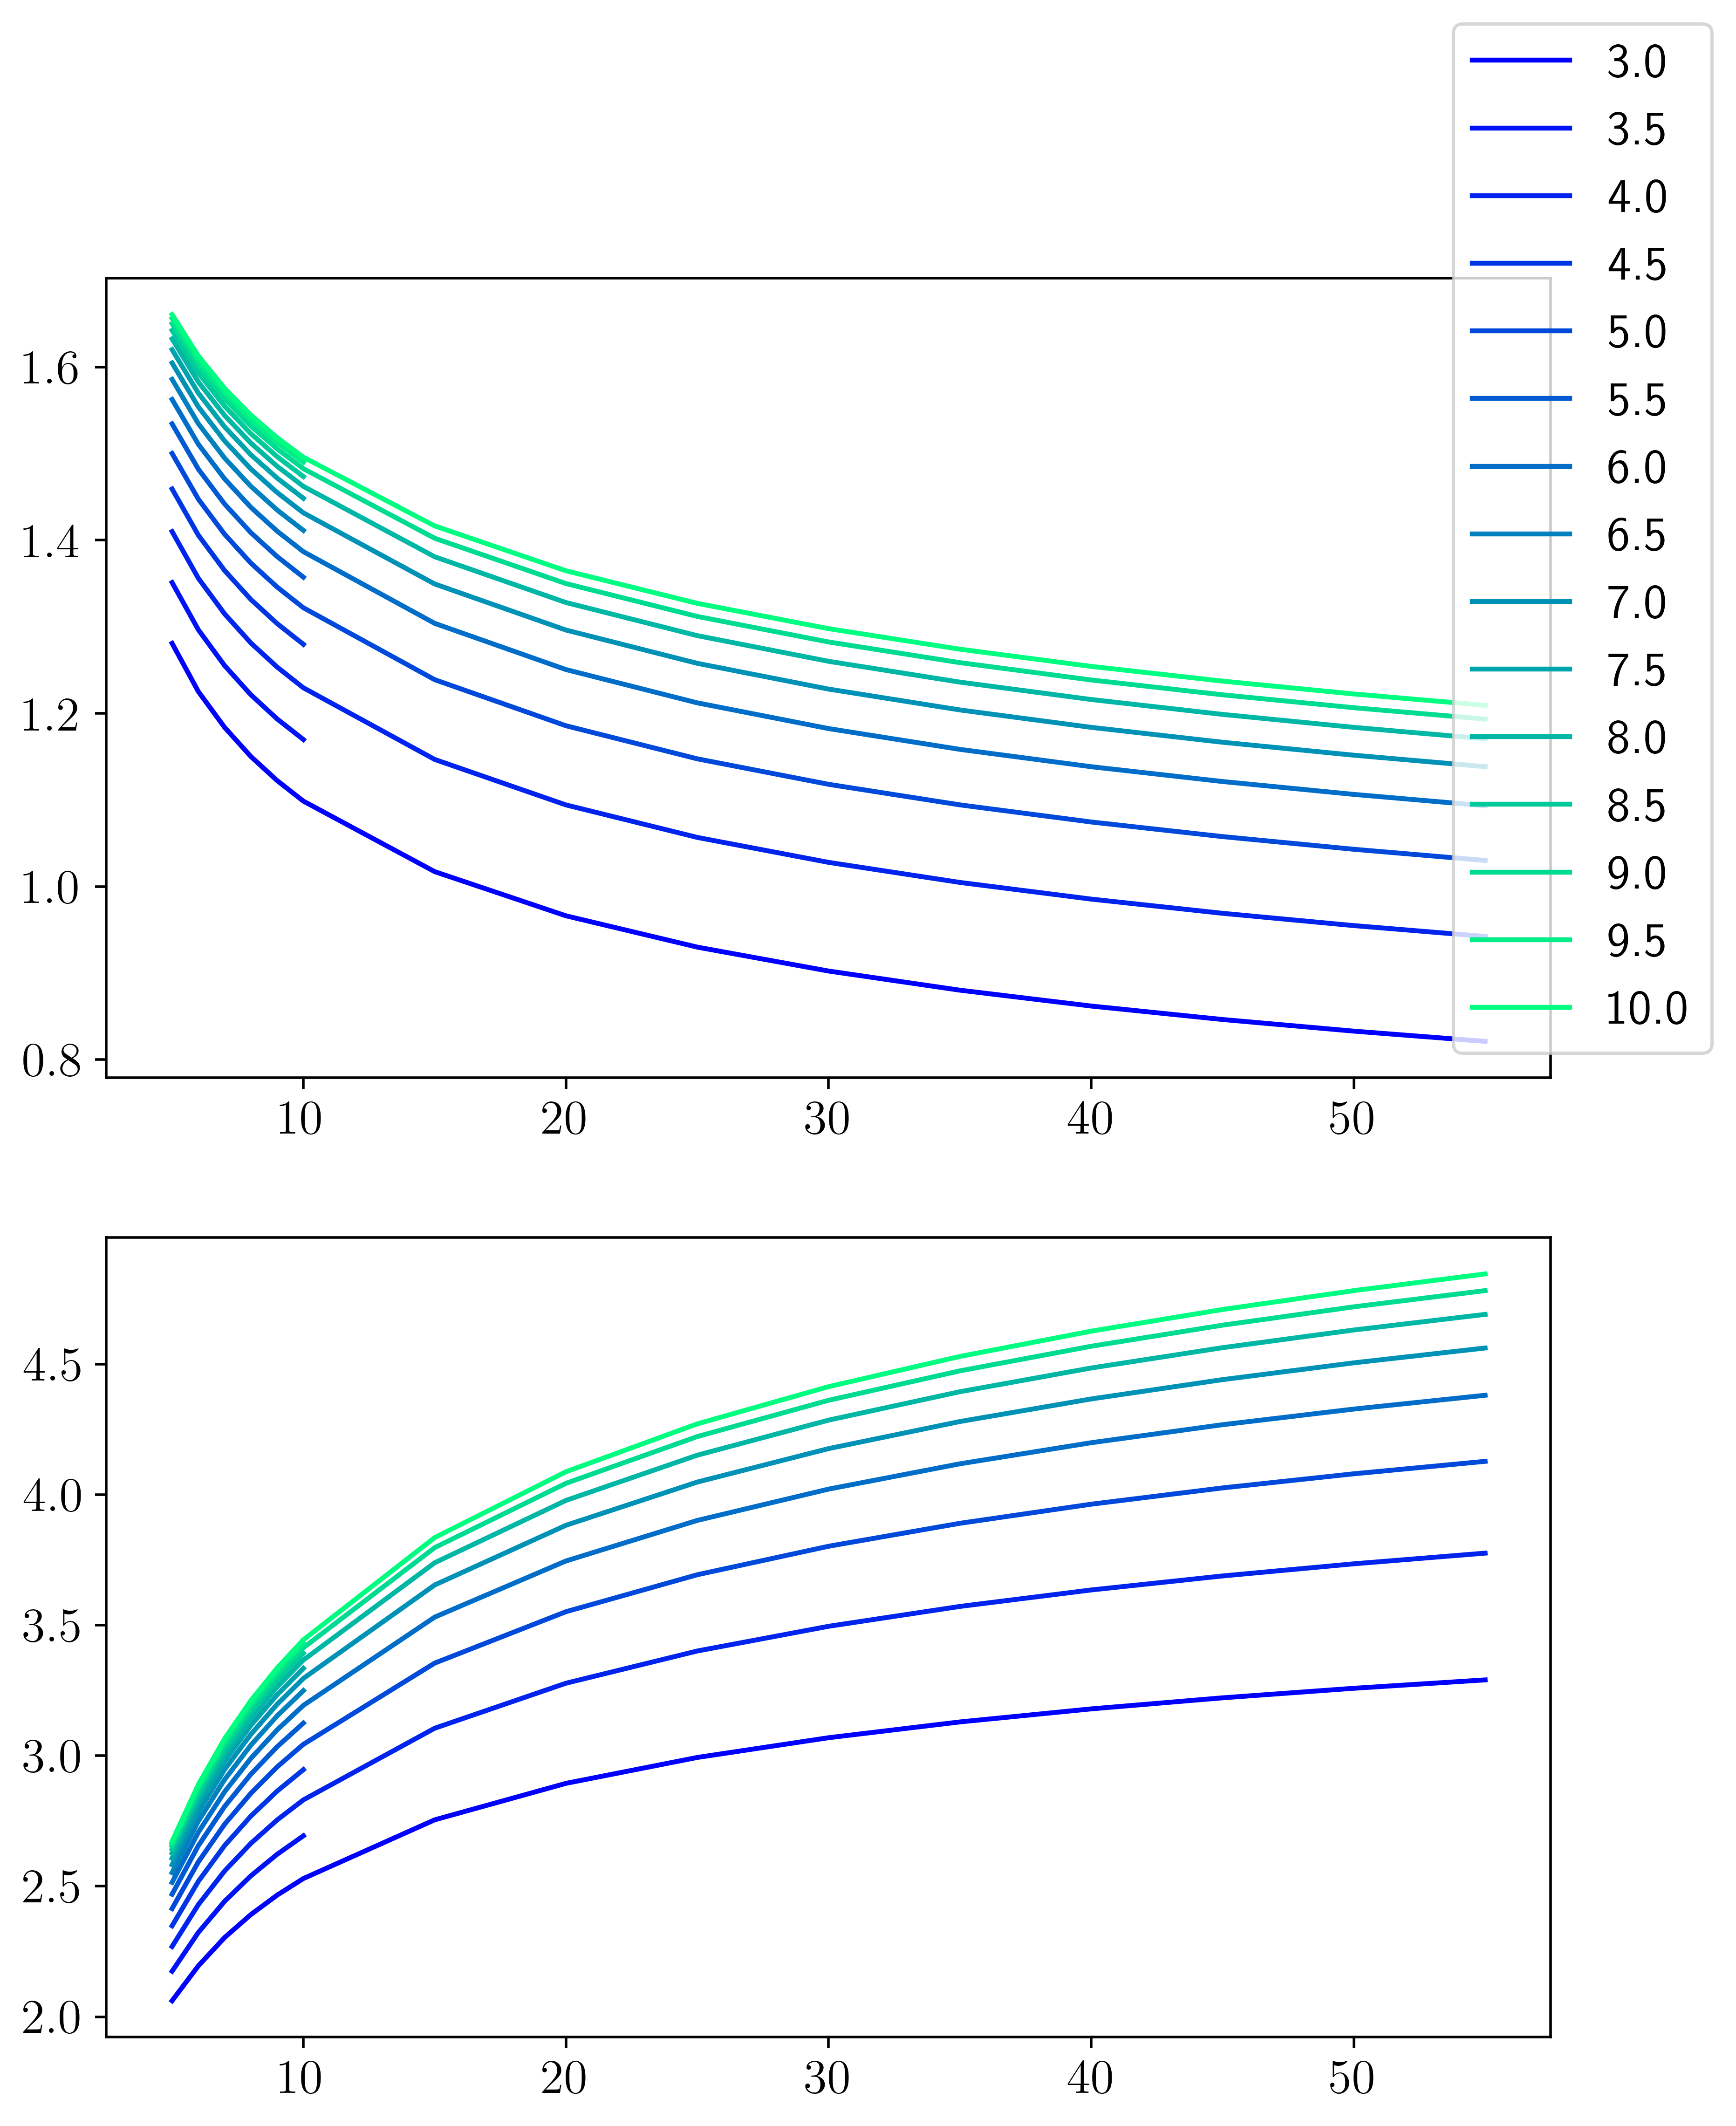

In [105]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 15})
figsize=np.array((16, 20)) * 0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
cmap = plt.get_cmap('winter')

fig, axs = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
t1 = data_A00.fx_a1
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
#
axi = axs[0]
for i0, ttph in enumerate(tph):
    tt1 = t1.loc[ttph]
    tvalue = tt1.values
    tidx = np.isfinite(tvalue)
#     axi.plot(tch, tvalue, '.-k', label=ttph)
    axi.plot(tch[tidx], tvalue[tidx], c=cmap( (ttph - tph.min()) / (tph.max() - tph.min()) ), label=ttph)
fig.legend()
#
axi = axs[1]
for i0, ttph in enumerate(tph):
    tt1 = t1.loc[ttph]
    tvalue = tt1.values
    tidx = np.isfinite(tvalue)
    axi.plot(tch[tidx], tvalue[tidx] * np.log(tch[tidx]), c=cmap( (ttph - tph.min()) / (tph.max() - tph.min()) ), label=ttph)
# fig.legend()


In [102]:
tvalue

array([1.6606 , 1.61277, 1.57536, 1.54441, 1.51839, 1.49583, 1.41648, 1.36465, 1.32704, 1.29781, 1.2741 ,
       1.25423, 1.23722, 1.22238, 1.20926])

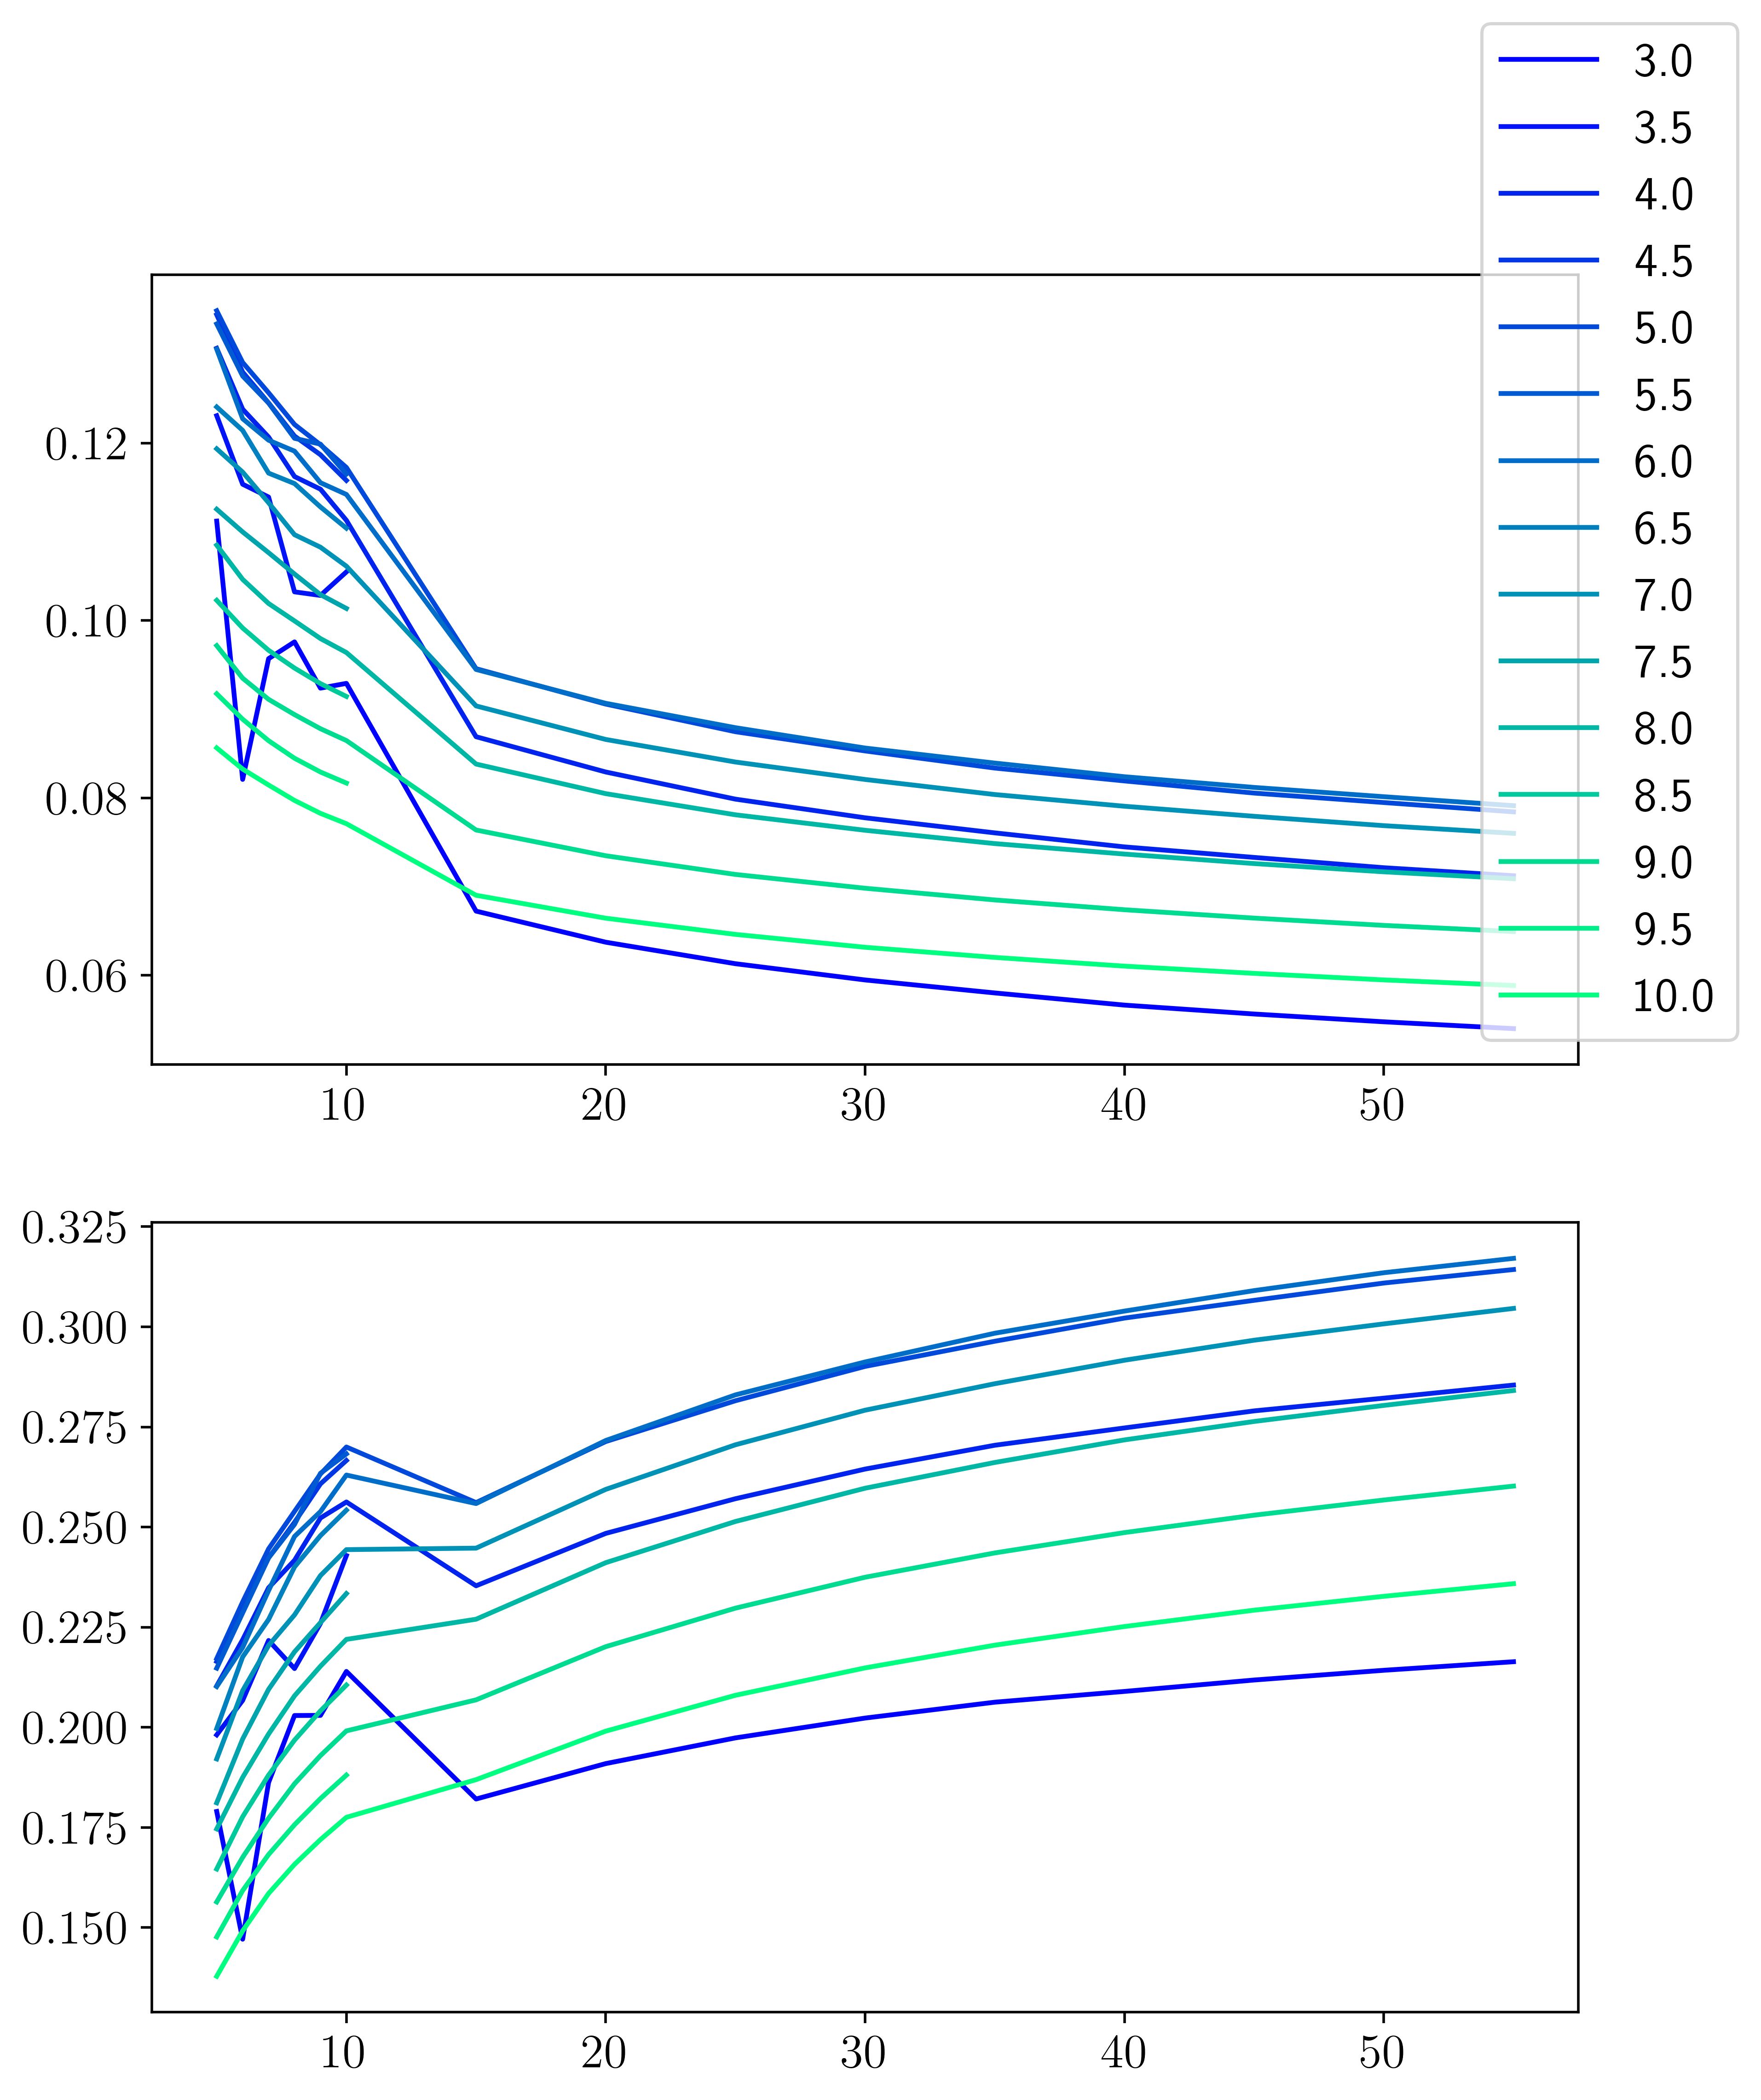

In [106]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 15})
figsize=np.array((16, 20)) * 0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
cmap = plt.get_cmap('winter')

fig, axs = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
t1 = data_A00.fx_a0
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
#
axi = axs[0]
for i0, ttph in enumerate(tph):
    tt1 = t1.loc[ttph]
    tvalue = tt1.values
    tidx = np.isfinite(tvalue)
    axi.plot(tch[tidx], tvalue[tidx], c=cmap( (ttph - tph.min()) / (tph.max() - tph.min()) ), label=ttph)
fig.legend()
#
axi = axs[1]
for i0, ttph in enumerate(tph):
    tt1 = t1.loc[ttph]
    tvalue = tt1.values
    tidx = np.isfinite(tvalue)
    axi.plot(tch[tidx], tvalue[tidx] * np.log(tch[tidx]), c=cmap( (ttph - tph.min()) / (tph.max() - tph.min()) ), label=ttph)
# fig.legend()


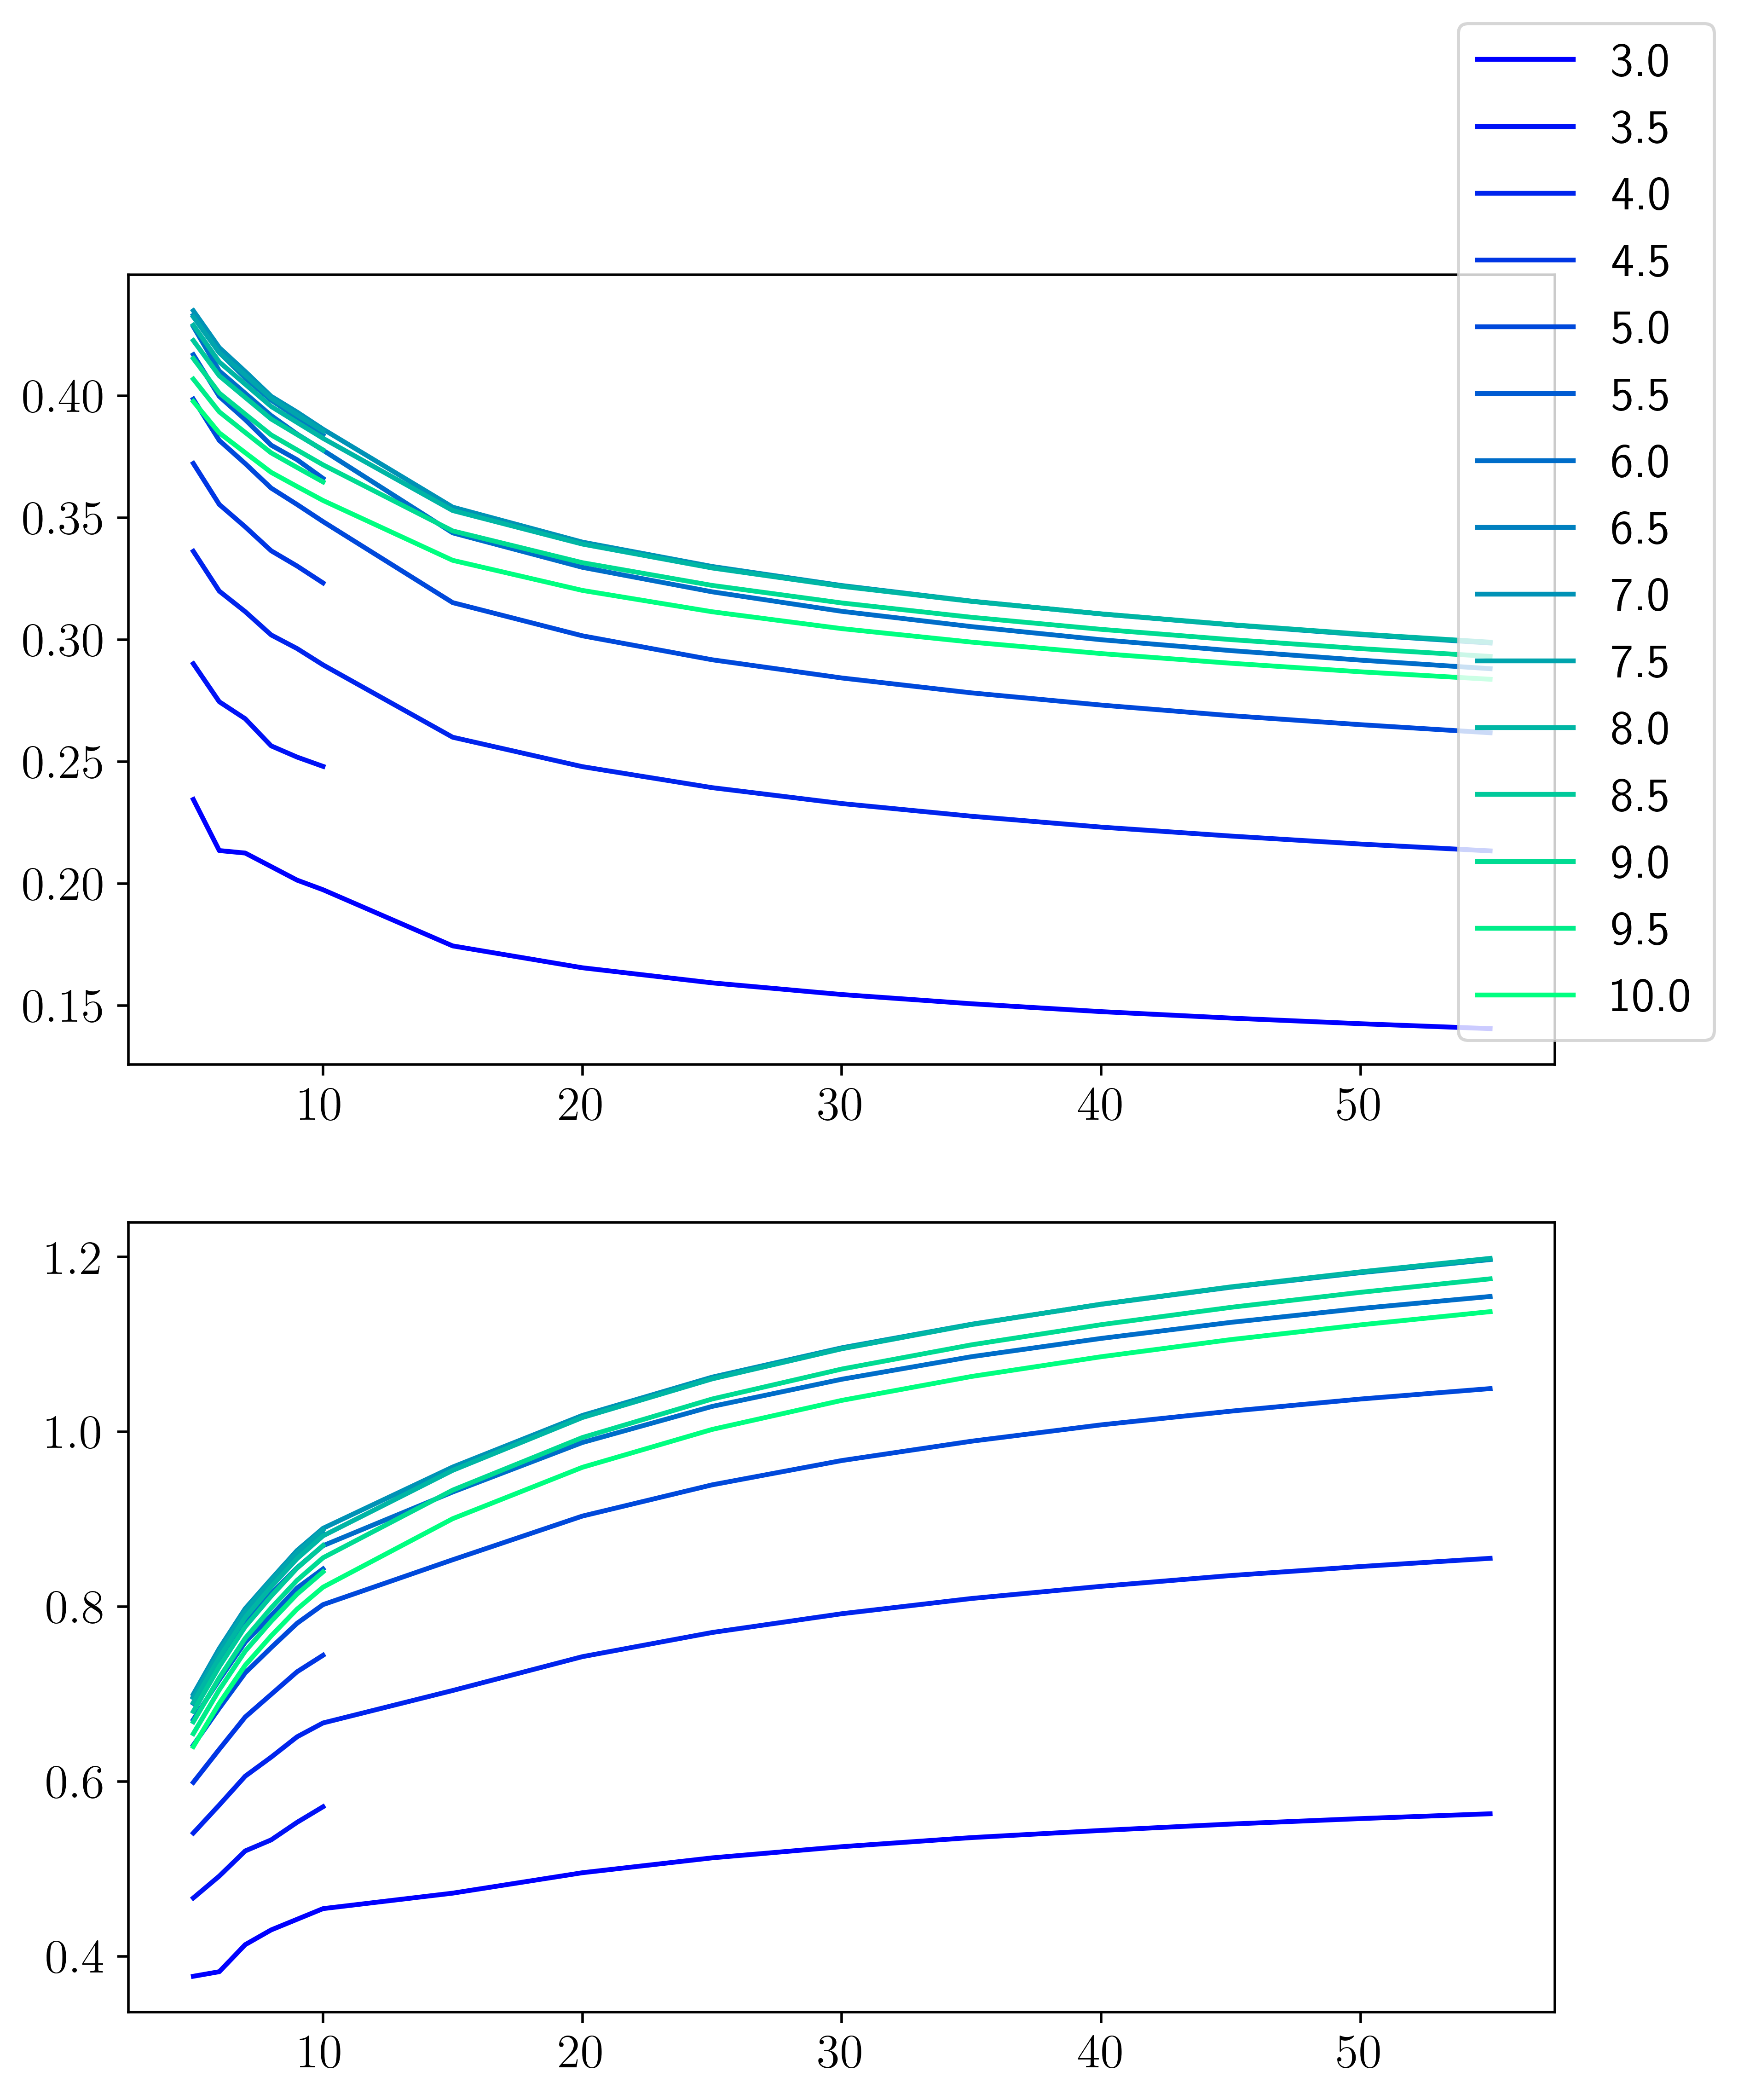

In [107]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 15})
figsize=np.array((16, 20)) * 0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
cmap = plt.get_cmap('winter')

fig, axs = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
t1 = data_A00.fz_a2
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
#
axi = axs[0]
for i0, ttph in enumerate(tph):
    tt1 = t1.loc[ttph]
    tvalue = tt1.values
    tidx = np.isfinite(tvalue)
    axi.plot(tch[tidx], tvalue[tidx], c=cmap( (ttph - tph.min()) / (tph.max() - tph.min()) ), label=ttph)
fig.legend()
#
axi = axs[1]
for i0, ttph in enumerate(tph):
    tt1 = t1.loc[ttph]
    tvalue = tt1.values
    tidx = np.isfinite(tvalue)
    axi.plot(tch[tidx], tvalue[tidx] * np.log(tch[tidx]), c=cmap( (ttph - tph.min()) / (tph.max() - tph.min()) ), label=ttph)
# fig.legend()
